In [2]:
import empiricaldist
import janitor
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats
import seaborn as sns
import sklearn.metrics
import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.stats as ss
import session_info
from dataset_encoding import alt_encodings

#### **Loading Data...**
##### Electric vehicles

In [3]:
filepath = {
    'FEV_data' : '../Datasets/cars/FEV data.csv',
    'electric_vehicle_population': '../Datasets/cars/Electric Vehicle Population Data.csv', 
    'electric_car': '../Datasets/cars/Electric Car.csv',
    'cars' : '../Datasets/cars/cars.csv',
    'cars_1' : '../Datasets/cars/Cars 1.csv'
    }

h2_prod = '../Datasets/H2_O2_production'

filepath_encodings = [alt_encodings(filepath[key])[1] for key in filepath.keys()]
filepath_encodings

['windows-1252', 'CP949', 'CP949', 'CP949', 'CP949']

In [4]:
fev_data_df = pd.read_csv(filepath['FEV_data'], encoding=filepath_encodings[0], header=0, sep=',')
fev_data_df.head(3)

,Car full name,Make,Model,Minimal price (gross) [PLN],Engine power [KM],Maximum torque [Nm],Type of brakes,Drive type,Battery capacity [kWh],Range (WLTP) [km],...,Permissable gross weight [kg],Maximum load capacity [kg],Number of seats,Number of doors,Tire size [in],Maximum speed [kph],Boot capacity (VDA) [l],Acceleration 0-100 kph [s],Maximum DC charging power [kW],mean - Energy consumption [kWh/100 km]
0,Audi e-tron 55 quattro,Audi,e-tron 55 quattro,345700,360,664,disc (front + rear),4WD,95.0,438,...,3130.0,640.0,5,5,19,200,660.0,5.7,150,24.45
1,Audi e-tron 50 quattro,Audi,e-tron 50 quattro,308400,313,540,disc (front + rear),4WD,71.0,340,...,3040.0,670.0,5,5,19,190,660.0,6.8,150,23.80
2,Audi e-tron S quattro,Audi,e-tron S quattro,414900,503,973,disc (front + rear),4WD,95.0,364,...,3130.0,565.0,5,5,20,210,660.0,4.5,150,27.55


In [5]:
electric_car_df = pd.read_csv(filepath['electric_car'], encoding=filepath_encodings[2], sep=',', header=0)
electric_car_df.head(3)

,Brand,Model,AccelSec,TopSpeed_KmH,Range_Km,Efficiency_WhKm,FastCharge_KmH,RapidCharge,PowerTrain,PlugType,BodyStyle,Segment,Seats,PriceEuro
0,Tesla,Model 3 Long Range Dual Motor,4.6,233,450,161,940,Yes,AWD,Type 2 CCS,Sedan,D,5,55480
1,Volkswagen,ID.3 Pure,10.0,160,270,167,250,Yes,RWD,Type 2 CCS,Hatchback,C,5,30000
2,Polestar,2,4.7,210,400,181,620,Yes,AWD,Type 2 CCS,Liftback,D,5,56440


#### **Data Collect and validation**
##### Type of data

In [6]:
fev_data_df.dtypes

Car full name                              object
Make                                       object
Model                                      object
Minimal price (gross) [PLN]                 int64
Engine power [KM]                           int64
Maximum torque [Nm]                         int64
Type of brakes                             object
Drive type                                 object
Battery capacity [kWh]                    float64
Range (WLTP) [km]                           int64
Wheelbase [cm]                            float64
Length [cm]                               float64
Width [cm]                                float64
Height [cm]                               float64
Minimal empty weight [kg]                   int64
Permissable gross weight [kg]             float64
Maximum load capacity [kg]                float64
Number of seats                             int64
Number of doors                             int64
Tire size [in]                              int64


In [7]:
(
    fev_data_df
        .dtypes
        .value_counts()
)

int64      10
float64    10
object      5
dtype: int64

In [8]:
electric_car_df.dtypes

Brand               object
Model               object
AccelSec           float64
TopSpeed_KmH         int64
Range_Km             int64
Efficiency_WhKm      int64
FastCharge_KmH      object
RapidCharge         object
PowerTrain          object
PlugType            object
BodyStyle           object
Segment             object
Seats                int64
PriceEuro            int64
dtype: object

In [9]:
(
    electric_car_df
        .dtypes
        .value_counts()
)

object     8
int64      5
float64    1
dtype: int64

#### **How many variables exist in our datasets**

In [10]:
(
    fev_data_df
        .shape
)

(53, 25)

In [11]:
(
    electric_car_df
        .shape
)

(103, 14)

#### **Explicit null values in our datasets**

In [12]:
(
    fev_data_df
        .isnull()
        .sum()
)

Car full name                             0
Make                                      0
Model                                     0
Minimal price (gross) [PLN]               0
Engine power [KM]                         0
Maximum torque [Nm]                       0
Type of brakes                            1
Drive type                                0
Battery capacity [kWh]                    0
Range (WLTP) [km]                         0
Wheelbase [cm]                            0
Length [cm]                               0
Width [cm]                                0
Height [cm]                               0
Minimal empty weight [kg]                 0
Permissable gross weight [kg]             8
Maximum load capacity [kg]                8
Number of seats                           0
Number of doors                           0
Tire size [in]                            0
Maximum speed [kph]                       0
Boot capacity (VDA) [l]                   1
Acceleration 0-100 kph [s]      

In [13]:
(
    fev_data_df
        .isnull()
        .sum()
        .sum()
)

30

In [14]:
(
    electric_car_df
        .isnull()
        .sum()
        .sum()
)

0

#### **How is the proportion of null values per variable**

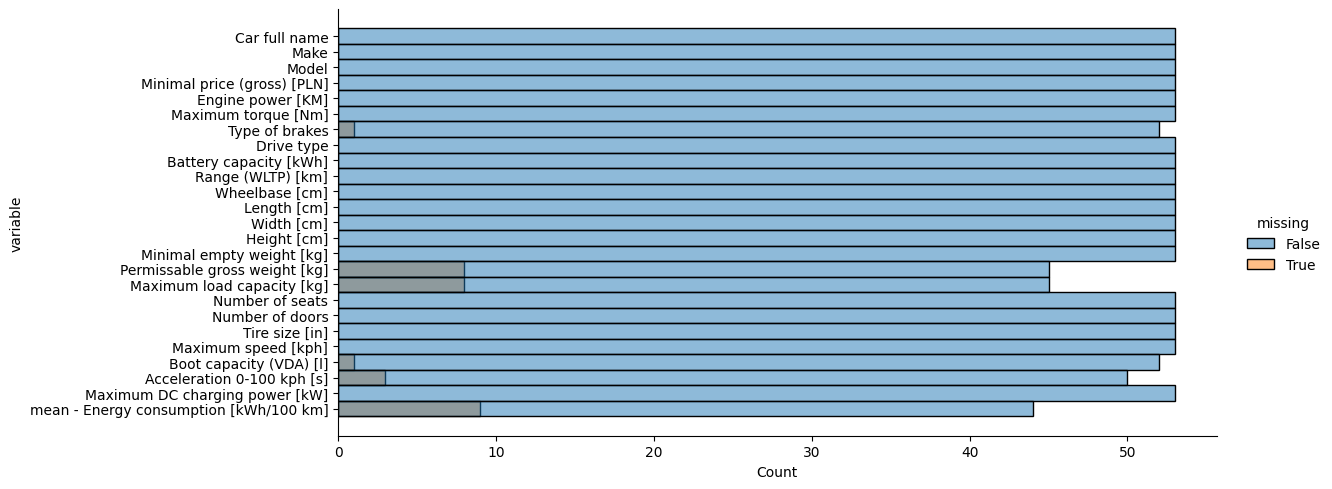

In [15]:
(
    fev_data_df
        .isnull()
        .melt(value_name='missing')
        .pipe(
            lambda df: (
                sns.displot(
                    data=df,
                    y='variable',
                    hue='missing',
                    aspect=2.5
                )
            )
        )
)
plt.show()

#### **How can we visualize null values in the whole dataset?**

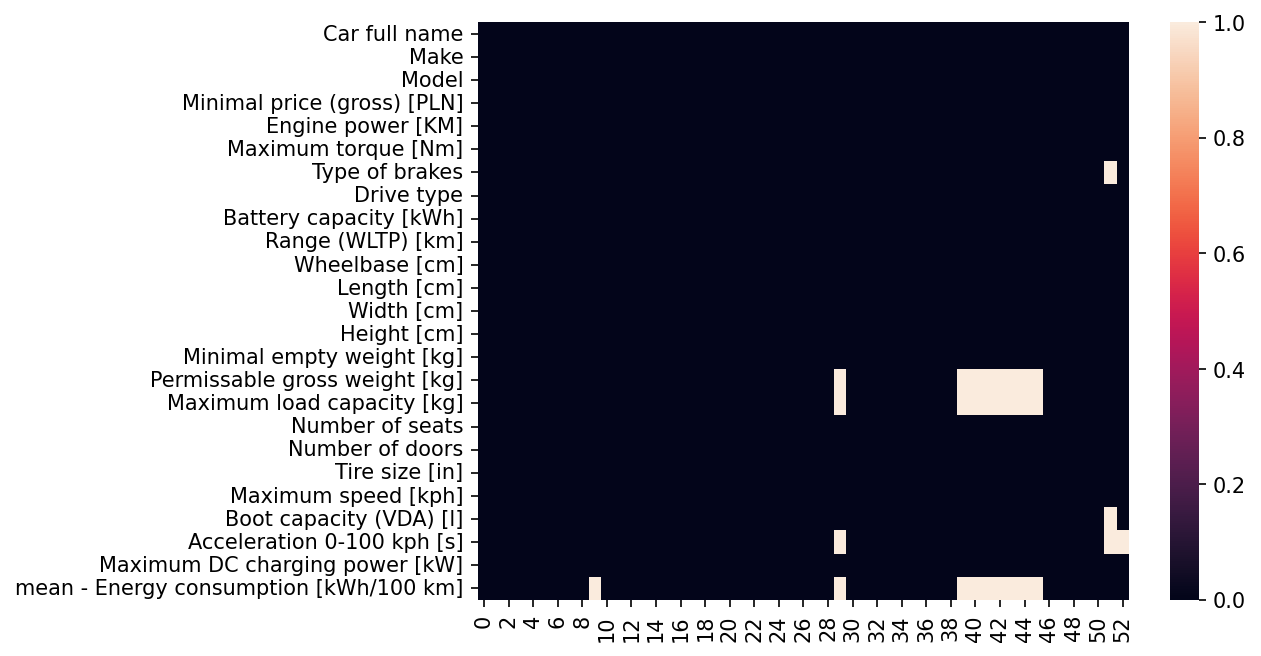

In [16]:
plt.figure(figsize=(7,5), dpi=150)
(
    fev_data_df
        .isnull()
        .T
        .pipe(
            lambda df: (
                sns.heatmap(
                    data=df
                )
            )
        )
)
plt.show()

#### **How many observations can we lost if we discard missing values?**

In [17]:
processed_fev_data = (
    fev_data_df
        .dropna()
)

processed_fev_data.head(2)

,Car full name,Make,Model,Minimal price (gross) [PLN],Engine power [KM],Maximum torque [Nm],Type of brakes,Drive type,Battery capacity [kWh],Range (WLTP) [km],...,Permissable gross weight [kg],Maximum load capacity [kg],Number of seats,Number of doors,Tire size [in],Maximum speed [kph],Boot capacity (VDA) [l],Acceleration 0-100 kph [s],Maximum DC charging power [kW],mean - Energy consumption [kWh/100 km]
0,Audi e-tron 55 quattro,Audi,e-tron 55 quattro,345700,360,664,disc (front + rear),4WD,95.0,438,...,3130.0,640.0,5,5,19,200,660.0,5.7,150,24.45
1,Audi e-tron 50 quattro,Audi,e-tron 50 quattro,308400,313,540,disc (front + rear),4WD,71.0,340,...,3040.0,670.0,5,5,19,190,660.0,6.8,150,23.80


#### **Counts and proportions**
#### **Prelude: Which statistical describe our dataset?**
##### Just numerical values 

For `processed_fev_data` dataset we have the following summary:

In [18]:
processed_fev_data.describe(include={np.number})

,Minimal price (gross) [PLN],Engine power [KM],Maximum torque [Nm],Battery capacity [kWh],Range (WLTP) [km],Wheelbase [cm],Length [cm],Width [cm],Height [cm],Minimal empty weight [kg],Permissable gross weight [kg],Maximum load capacity [kg],Number of seats,Number of doors,Tire size [in],Maximum speed [kph],Boot capacity (VDA) [l],Acceleration 0-100 kph [s],Maximum DC charging power [kW],mean - Energy consumption [kWh/100 km]
count,42.000000,42.000000,42.000000,42.000000,42.000000,42.000000,42.000000,42.000000,42.000000,42.000000,42.000000,42.000000,42.000000,42.000000,42.000000,42.000000,42.000000,42.000000,42.000000,42.000000
mean,235065.785714,237.666667,425.166667,58.842857,351.738095,269.823810,433.509524,184.754762,154.980952,1821.214286,2267.809524,510.452381,4.761905,4.809524,17.547619,169.500000,404.333333,7.892857,109.666667,18.610714
std,154079.039546,149.006084,233.915965,23.287484,96.788192,22.785627,49.268883,14.835574,9.454519,469.155626,543.690651,132.997745,0.790478,0.505487,1.837315,35.674853,146.550693,2.570697,61.602054,4.134293
min,82050.000000,82.000000,160.000000,17.600000,148.000000,187.300000,269.500000,164.500000,137.800000,1035.000000,1310.000000,290.000000,2.000000,3.000000,14.000000,130.000000,171.000000,2.800000,22.000000,13.100000
25%,140650.000000,136.000000,260.000000,39.200000,279.250000,256.325000,406.625000,178.725000,151.200000,1516.250000,1881.500000,440.000000,4.250000,5.000000,16.000000,146.250000,310.250000,6.800000,62.500000,15.600000
50%,166945.000000,184.000000,317.500000,52.000000,352.500000,270.000000,431.800000,180.250000,156.000000,1621.500000,2099.500000,485.500000,5.000000,5.000000,17.000000,160.000000,371.000000,7.900000,100.000000,16.875000
75%,316875.000000,313.000000,540.000000,78.650000,434.750000,290.000000,475.500000,193.500000,160.500000,2248.750000,2855.000000,565.000000,5.000000,5.000000,19.000000,187.500000,497.000000,9.650000,143.750000,22.937500
max,794000.000000,625.000000,1050.000000,95.000000,549.000000,327.500000,496.300000,255.800000,190.000000,2695.000000,3130.000000,1056.000000,8.000000,5.000000,21.000000,260.000000,660.000000,13.100000,270.000000,27.550000


For `electric_car_df` dataset we have the following summary:

In [19]:
electric_car_df.describe(include={np.number})

,AccelSec,TopSpeed_KmH,Range_Km,Efficiency_WhKm,Seats,PriceEuro
count,103.000000,103.000000,103.000000,103.000000,103.000000,103.000000
mean,7.396117,179.194175,338.786408,189.165049,4.883495,55811.563107
std,3.017430,43.573030,126.014444,29.566839,0.795834,34134.665280
min,2.100000,123.000000,95.000000,104.000000,2.000000,20129.000000
25%,5.100000,150.000000,250.000000,168.000000,5.000000,34429.500000
50%,7.300000,160.000000,340.000000,180.000000,5.000000,45000.000000
75%,9.000000,200.000000,400.000000,203.000000,5.000000,65000.000000
max,22.400000,410.000000,970.000000,273.000000,7.000000,215000.000000


#### Just categorical values

In [20]:
processed_fev_data.describe(include='object')

,Car full name,Make,Model,Type of brakes,Drive type
count,42,42,42,42,42
unique,42,19,42,2,3
top,Audi e-tron 55 quattro,Audi,e-tron 55 quattro,disc (front + rear),2WD (front)
freq,1,6,1,35,20


In [21]:
electric_car_df.describe(include='object')

,Brand,Model,FastCharge_KmH,RapidCharge,PowerTrain,PlugType,BodyStyle,Segment
count,103,103,103,103,103,103,103,103
unique,33,102,51,2,3,4,9,8
top,Tesla,e-Soul 64 kWh,230,Yes,AWD,Type 2 CCS,SUV,C
freq,13,2,6,98,41,90,45,30


#### **How counts can be visualized?**
##### Pandas

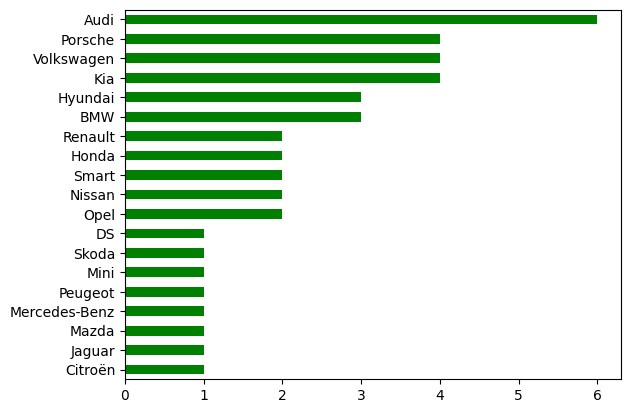

In [22]:
(
    processed_fev_data
        .Make
        .value_counts()
        .sort_values(ascending=True)
        .plot(
            kind='barh',
            color='green'
        )
)
plt.show()

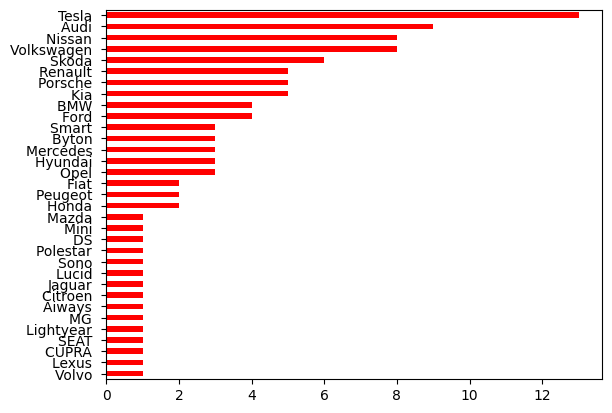

In [23]:
(
    electric_car_df
        .Brand
        .value_counts()
        .sort_values(ascending=True)
        .plot(
            kind='barh',
            color='red'
        )
)
plt.show()

In [24]:
(
    electric_car_df
        .groupby('Brand')
        .count()
        .sort_values('Model', ascending=False)
        .iloc[:5, :1]
)

,Model
Brand,
Tesla,13
Audi,9
Nissan,8
Volkswagen,8
Skoda,6


##### Seaborn

In [25]:
order_fev = processed_fev_data['Make'].value_counts().head(5).index
order_fev

Index(['Audi', 'Porsche', 'Volkswagen', 'Kia', 'Hyundai'], dtype='object')

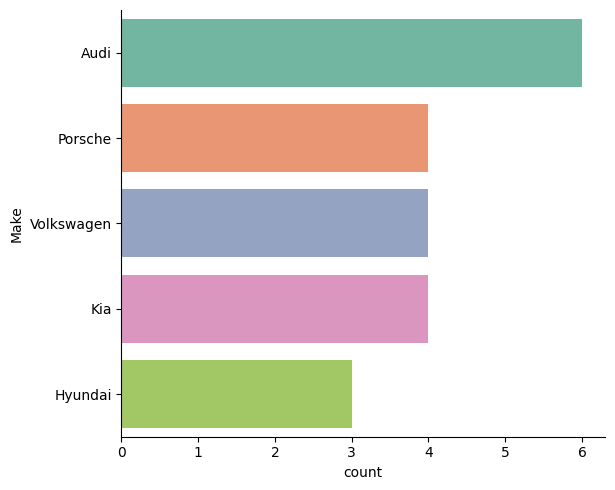

In [26]:
sns.catplot(
    data=processed_fev_data,
    y='Make',
    kind='count',
    aspect=1.25,
    palette='Set2',
    order=order_fev
    )
plt.tight_layout()
plt.show()

In [27]:
order_brand = electric_car_df.Brand.value_counts().head(5).index

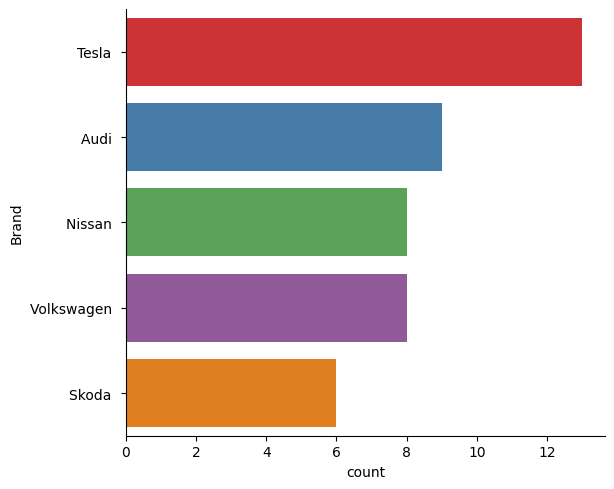

In [28]:
sns.catplot(
    data=electric_car_df,
    y='Brand',
    kind='count',
    palette='Set1',
    aspect=1.25,
    order=order_brand
)
plt.show()

In [29]:
fast_charge_brands = electric_car_df.groupby('RapidCharge')['Brand'].value_counts()

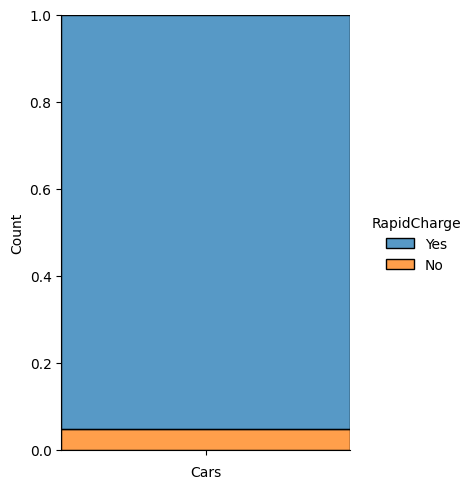

In [30]:
(
    electric_car_df
        .add_column('Cars', '')
        .pipe(
            lambda df:(
                sns.displot(
                    data=df,
                    x='Cars',
                    hue='RapidCharge',
                    multiple='fill',
                    height=5,
                    aspect=0.75
                )
            )
        )
)
plt.show()

#### Central tendency measures

In [31]:
electric_car_df.sort_values('PriceEuro', ascending=False).head(5)

,Brand,Model,AccelSec,TopSpeed_KmH,Range_Km,Efficiency_WhKm,FastCharge_KmH,RapidCharge,PowerTrain,PlugType,BodyStyle,Segment,Seats,PriceEuro
51,Tesla,Roadster,2.1,410,970,206,920,Yes,AWD,Type 2 CCS,Cabrio,S,4,215000
16,Porsche,Taycan Turbo S,2.8,260,375,223,780,Yes,AWD,Type 2 CCS,Sedan,F,4,180781
72,Porsche,Taycan Cross Turismo,3.5,250,385,217,770,Yes,AWD,Type 2 CCS,Station,F,4,150000
48,Lightyear,One,10.0,150,575,104,540,Yes,AWD,Type 2 CCS,Liftback,F,5,149000
79,Porsche,Taycan Turbo,3.2,260,390,215,810,Yes,AWD,Type 2 CCS,Sedan,F,4,148301


##### Mean

In [32]:
electric_car_df.mean(numeric_only=True)

AccelSec               7.396117
TopSpeed_KmH         179.194175
Range_Km             338.786408
Efficiency_WhKm      189.165049
Seats                  4.883495
PriceEuro          55811.563107
dtype: float64

##### Median

In [33]:
electric_car_df.median(numeric_only=True)

AccelSec               7.3
TopSpeed_KmH         160.0
Range_Km             340.0
Efficiency_WhKm      180.0
Seats                  5.0
PriceEuro          45000.0
dtype: float64

##### Mode

In [34]:
electric_car_df.mode().head(1)

,Brand,Model,AccelSec,TopSpeed_KmH,Range_Km,Efficiency_WhKm,FastCharge_KmH,RapidCharge,PowerTrain,PlugType,BodyStyle,Segment,Seats,PriceEuro
0,Tesla,e-Soul 64 kWh,9.0,150,250,168.0,230,Yes,AWD,Type 2 CCS,SUV,C,5.0,45000.0


<Figure size 640x480 with 0 Axes>

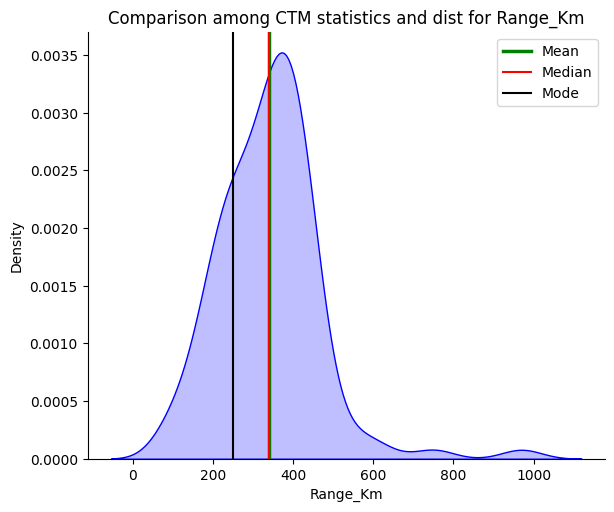

In [35]:
plt.figure()
sns.displot(
    data=electric_car_df,
    x='Range_Km',
    kind='kde',
    fill=True,
    color='blue',
    aspect=1.25
)
plt.axvline(x = electric_car_df.Range_Km.mean(), color='green', linewidth=2.5, label='Mean')
plt.axvline(x = electric_car_df.Range_Km.median(), color='red', linestyle='-', label='Median')
plt.axvline(x = 250, color='black', linestyle='-', label='Mode')
plt.title("Comparison among CTM statistics and dist for Range_Km")
plt.legend()
plt.show()

<Figure size 640x480 with 0 Axes>

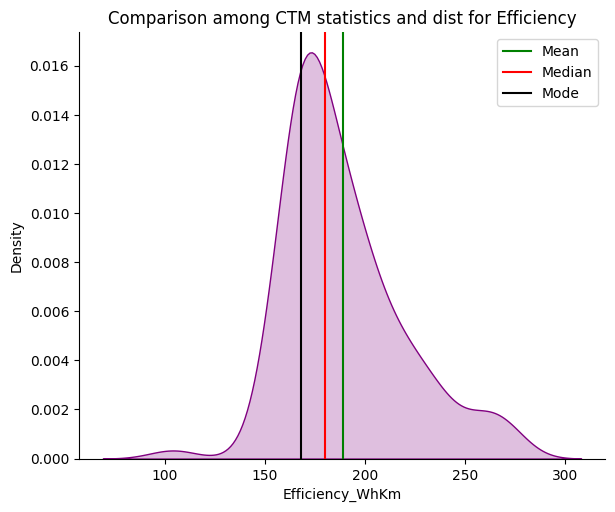

In [36]:
plt.figure()
sns.displot(
    data=electric_car_df,
    x='Efficiency_WhKm',
    kind='kde',
    fill=True,
    color='purple',
    aspect=1.25
)
plt.axvline(x = electric_car_df.Efficiency_WhKm.mean(), color='green', label='Mean')
plt.axvline(x = electric_car_df.Efficiency_WhKm.median(), color='red', linestyle='-', label='Median')
plt.axvline(x = 168, color='black', linestyle='-', label='Mode')
plt.title("Comparison among CTM statistics and dist for Efficiency")
plt.legend()
plt.show()

### Dispersion measures
##### Which is the maximum value?

In [37]:
electric_car_df.max()

Brand                      Volvo 
Model                        iX3 
AccelSec                     22.4
TopSpeed_KmH                  410
Range_Km                      970
Efficiency_WhKm               273
FastCharge_KmH                940
RapidCharge                   Yes
PowerTrain                    RWD
PlugType           Type 2 CHAdeMO
BodyStyle                 Station
Segment                         S
Seats                           7
PriceEuro                  215000
dtype: object

In [38]:
electric_car_df.min()

Brand                     Aiways 
Model                           2
AccelSec                      2.1
TopSpeed_KmH                  123
Range_Km                       95
Efficiency_WhKm               104
FastCharge_KmH                  -
RapidCharge                    No
PowerTrain                    AWD
PlugType           Type 1 CHAdeMO
BodyStyle                  Cabrio
Segment                         A
Seats                           2
PriceEuro                   20129
dtype: object

##### Variable range
**Warning**: FastCharge_KmH has to be cleaned

In [39]:
electric_car_df.max(numeric_only=True)-electric_car_df.min(numeric_only=True)

AccelSec               20.3
TopSpeed_KmH          287.0
Range_Km              875.0
Efficiency_WhKm       169.0
Seats                   5.0
PriceEuro          194871.0
dtype: float64

##### Standard deviation

In [40]:
electric_car_df.std(numeric_only=True)

AccelSec               3.017430
TopSpeed_KmH          43.573030
Range_Km             126.014444
Efficiency_WhKm       29.566839
Seats                  0.795834
PriceEuro          34134.665280
dtype: float64

In [41]:
(
    electric_car_df
        .quantile(numeric_only=True, q=[0.25, 0.50, 0.75])
        .T
        .rename_axis('variable')
        .reset_index()
        .assign(
            iqr = lambda df:(
                df[0.75] - df[0.25]
            )
        )
)

,variable,0.25,0.5,0.75,iqr
0,AccelSec,5.1,7.3,9.0,3.9
1,TopSpeed_KmH,150.0,160.0,200.0,50.0
2,Range_Km,250.0,340.0,400.0,150.0
3,Efficiency_WhKm,168.0,180.0,203.0,35.0
4,Seats,5.0,5.0,5.0,0.0
5,PriceEuro,34429.5,45000.0,65000.0,30570.5


#### Univariate distribution
##### Histogram

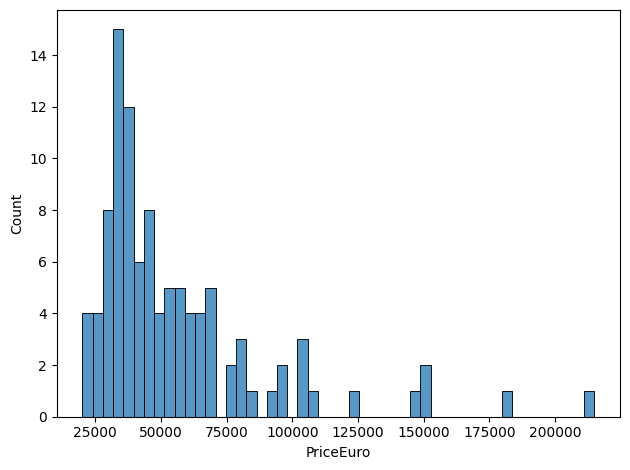

In [42]:
sns.histplot(
    data=electric_car_df,
    x='PriceEuro',
    bins=50
)
plt.tight_layout()
plt.show()

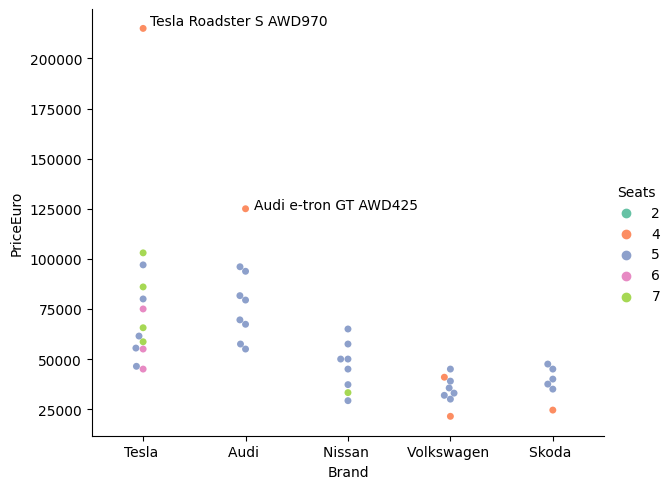

In [43]:
sns.catplot(
    data=electric_car_df,
    y='PriceEuro',
    x='Brand',
    kind='swarm',
    order=order_brand,
    palette='Set2',
    hue='Seats',
    aspect=1.25
)
plt.annotate(
    text = 'Tesla Roadster S AWD970', 
    xy=(0, 210000), 
    xytext=(5, 10), 
    textcoords='offset points'
)
plt.annotate(
    text='Audi e-tron GT AWD425',
    xy=(0, 125000),
    xytext=(80,0),
    textcoords='offset points'
)
plt.show()

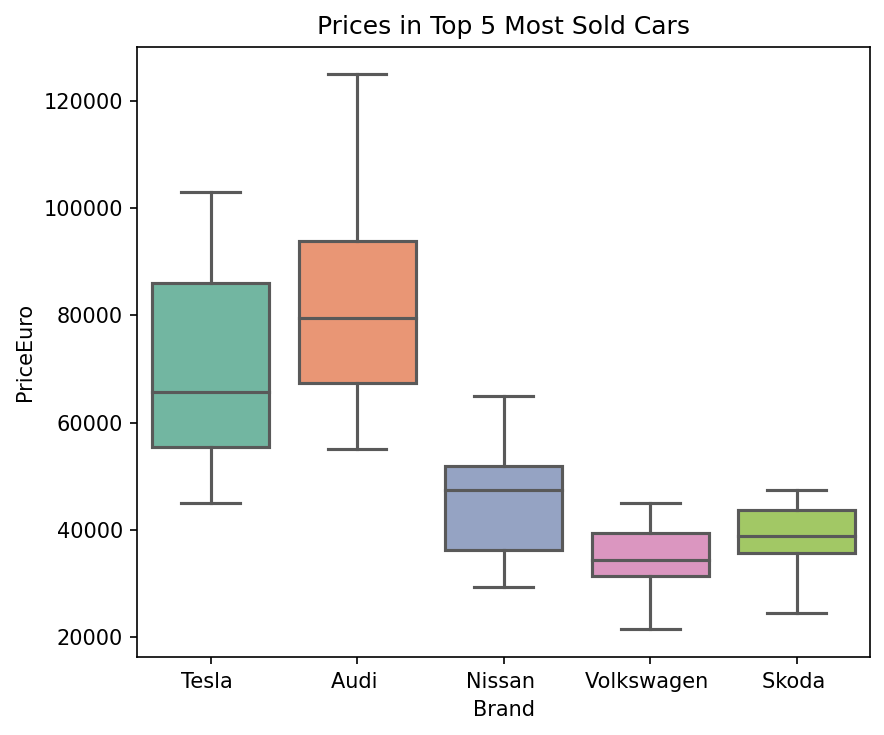

In [44]:
plt.figure(figsize=(6,5), dpi=150)
sns.boxplot(
    data=electric_car_df,
    x='Brand',
    y='PriceEuro',
    order=order_brand,
    palette='Set2',
    showfliers=False
)
plt.title('Prices in Top 5 Most Sold Cars')
plt.tight_layout()
plt.show()

### **Distributions: PMFs, CDFs y PDFs**
#### Probability mass function (PMF)
##### Using `seaborn`

In [45]:
mean = electric_car_df.Range_Km.mean()
mu = electric_car_df.Range_Km.std()
norm_dist = scipy.stats.norm(mean, mu)
x = np.arange(electric_car_df.Range_Km.min(), electric_car_df.Range_Km.max(), 0.1)
y = [norm_dist.pdf(value)*10 for value in x]


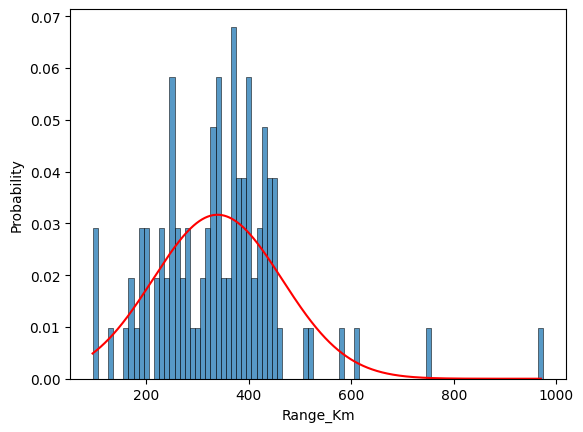

In [46]:
sns.histplot(
    data=electric_car_df,
    x='Range_Km',
    binwidth=10,
    stat='probability'
)
plt.plot(x, y, 'r-')
plt.show()

##### Using `empirical_dist`

In [47]:
pmf_range_km = empiricaldist.Pmf.from_seq(
    electric_car_df.Range_Km,
    normalize=True
)

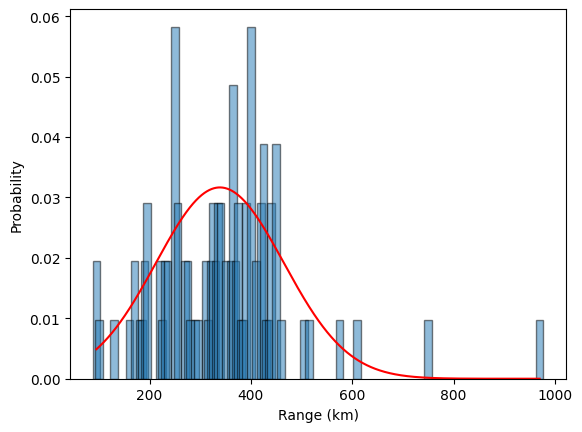

In [48]:
pmf_range_km.bar(width=15, edgecolor='black', alpha=0.5)
plt.xlabel('Range (km)')
plt.ylabel('Probability')
plt.plot(x,y,'r-')
plt.show()

In [49]:
print(f"Probability of getting a car with a range of 450 is {round(pmf_range_km(450), 2)}")

Probability of getting a car with a range of 450 is 0.04


#### Empirical function of cumulated density probability (ECDFs)
##### Using `seaborn`

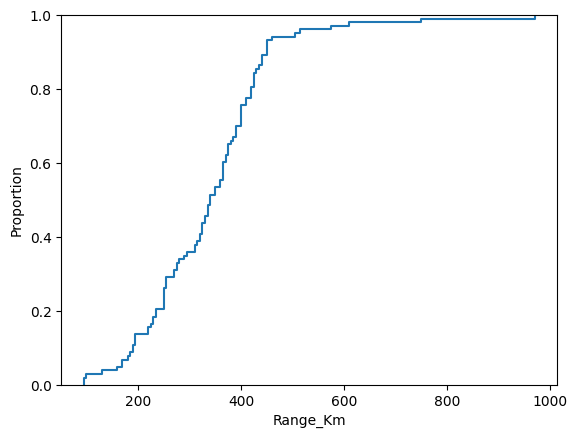

In [50]:
sns.ecdfplot(
    data=electric_car_df,
    x='Range_Km'
)
plt.show()

#### Using `empirical_dist`

In [51]:
cdf_range_km = empiricaldist.Cdf.from_seq(
    electric_car_df.Range_Km,
    normalize=True
)

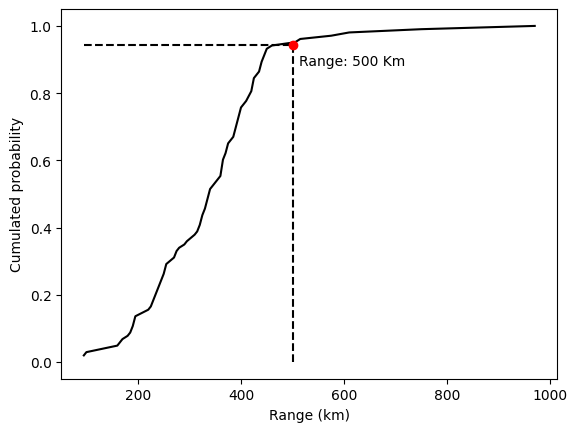

In [52]:
plt.plot(cdf_range_km, color='black', linestyle='-')
plt.xlabel('Range (km)')
plt.ylabel('Cumulated probability')

q= 500
p = cdf_range_km.forward(q) #why forward?

plt.vlines(
    x=q,
    ymin=0,
    ymax=p,
    color = 'black',
    linestyle='dashed'
)

plt.hlines(
    y=p,
    xmin=cdf_range_km.qs[0],
    xmax=q,
    color='black',
    linestyle='dashed'
)

plt.annotate(
    text = 'Range: 500 Km', 
    xy=(q, p-0.1), 
    xytext=(5, 10), 
    textcoords='offset points'
)

plt.plot(q, p, 'ro')
plt.show()

#### Density probability function

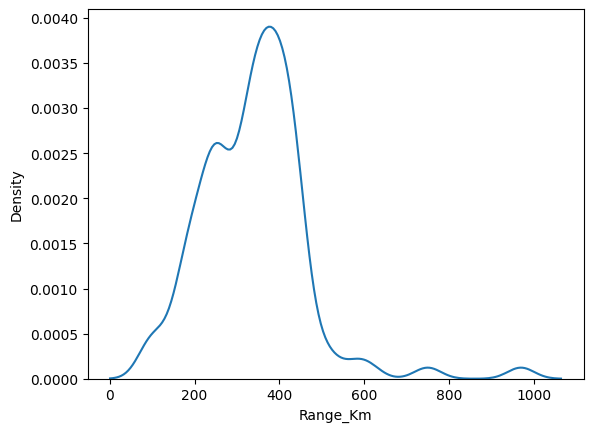

In [53]:
sns.kdeplot(
    data=electric_car_df,
    x='Range_Km',
    bw_method=0.25
)
plt.show()

##### Normal cumulated distribution fit

In [54]:
stats = electric_car_df.Range_Km.describe()
stats

count    103.000000
mean     338.786408
std      126.014444
min       95.000000
25%      250.000000
50%      340.000000
75%      400.000000
max      970.000000
Name: Range_Km, dtype: float64

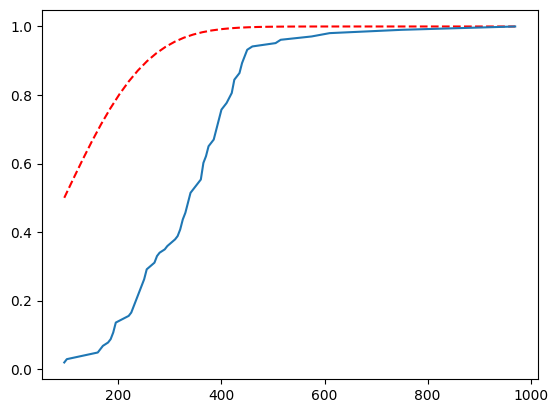

In [55]:
np.random.seed(42)
xs = np.linspace(stats['min'], stats['max'])
ys = scipy.stats.norm(stats['min'], stats['std']).cdf(xs)
plt.plot(xs, ys, 'r--')

empiricaldist.Cdf.from_seq(
    electric_car_df.Range_Km,
    normalize=True
).plot()

plt.show()

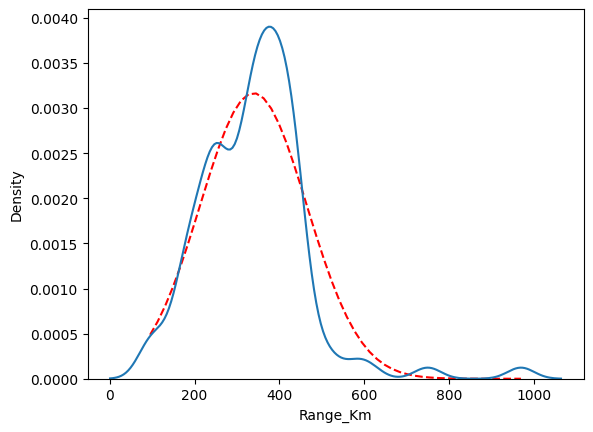

In [56]:
np.random.seed(42)
xs = np.linspace(stats['min'], stats['max'])
ys = scipy.stats.norm(stats['mean'], stats['std']).pdf(xs)
plt.plot(xs, ys, 'r--')

sns.kdeplot(
    data=electric_car_df,
    x='Range_Km',
    bw_method=0.25
)

plt.show()

### **Relationships**

In [57]:
electric_car_df.corr(numeric_only=True)

,AccelSec,TopSpeed_KmH,Range_Km,Efficiency_WhKm,Seats,PriceEuro
AccelSec,1.000000,-0.786195,-0.677062,-0.382904,-0.175335,-0.627174
TopSpeed_KmH,-0.786195,1.000000,0.746662,0.355675,0.126470,0.829057
Range_Km,-0.677062,0.746662,1.000000,0.313077,0.300163,0.674844
Efficiency_WhKm,-0.382904,0.355675,0.313077,1.000000,0.301230,0.396705
Seats,-0.175335,0.126470,0.300163,0.301230,1.000000,0.020920
PriceEuro,-0.627174,0.829057,0.674844,0.396705,0.020920,1.000000


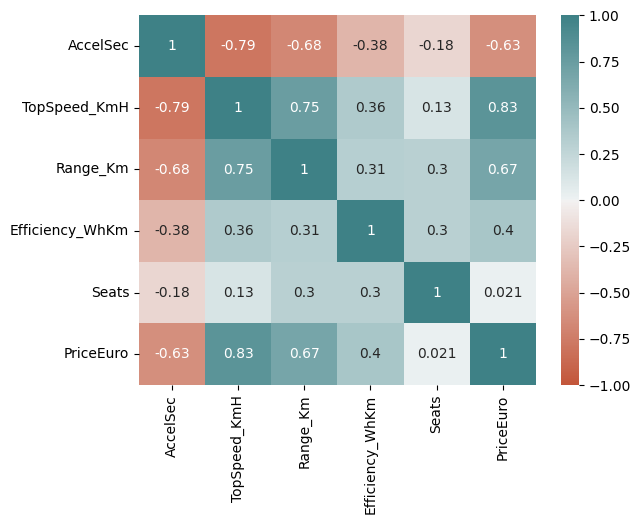

In [58]:
sns.heatmap(
    data=electric_car_df.corr(numeric_only=True),
    cmap=sns.diverging_palette(20, 200, as_cmap=True),
    annot=True,
    center=0,
    vmin=-1,
    vmax=1
)
plt.show()

In [75]:
selected_brands = ['Tesla ', 'Audi ', 'Nissan ', 'Volkswagen ', 'Skoda ', 'Renault ']
filtered_df = electric_car_df[electric_car_df.Brand.isin(selected_brands)]

In [76]:
filtered_df.corr(numeric_only=True).iloc[5:6, :]

,AccelSec,TopSpeed_KmH,Range_Km,Efficiency_WhKm,Seats,PriceEuro
PriceEuro,-0.629016,0.900213,0.746751,0.455622,0.013626,1.0


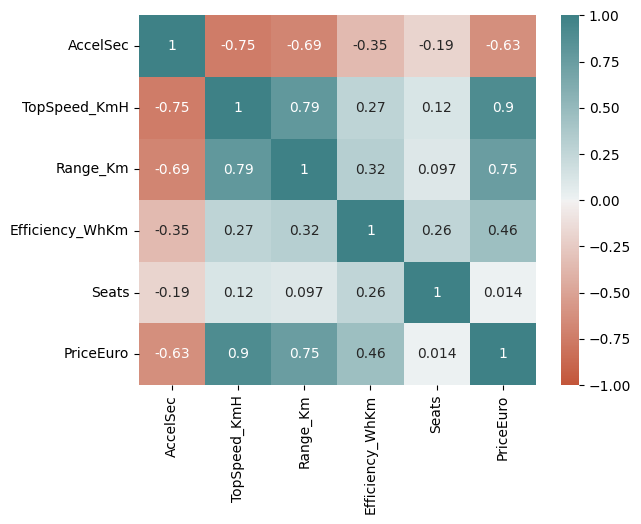

In [77]:
sns.heatmap(
    data=filtered_df.corr(numeric_only=True),
    cmap=sns.diverging_palette(20, 200, as_cmap=True),
    center=0,
    vmin=-1,
    vmax=1,
    annot=True   
)
plt.show()

### **Simple linear regression analysis**

In [111]:
x_1 = filtered_df.Range_Km.values
y_1 = filtered_df.PriceEuro.values

reg_1 = scipy.stats.linregress(x=x_1, y=y_1)


In [112]:
fx_1 = np.array([x_1.min(), x_1.max()])
fy_1 = reg_1.slope*fx_1 + reg_1.intercept

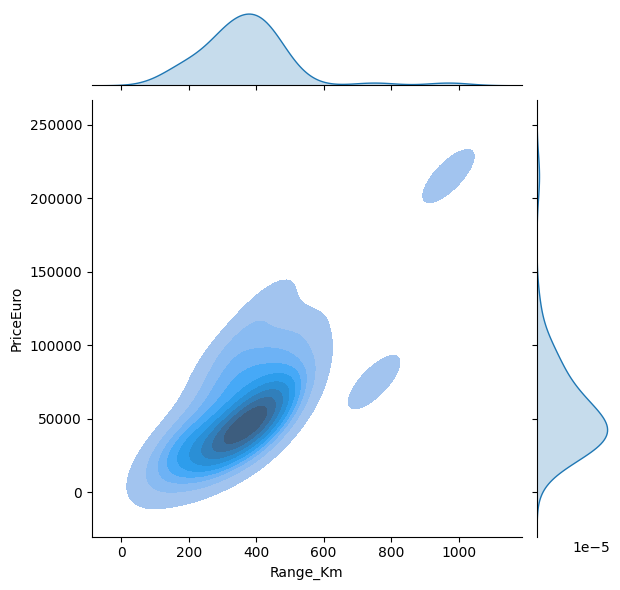

In [123]:
sns.jointplot(
    data=filtered_df,
    x='Range_Km',
    y='PriceEuro',
    kind='kde',
    fill=True
    # hue='Brand'
)
plt.show()

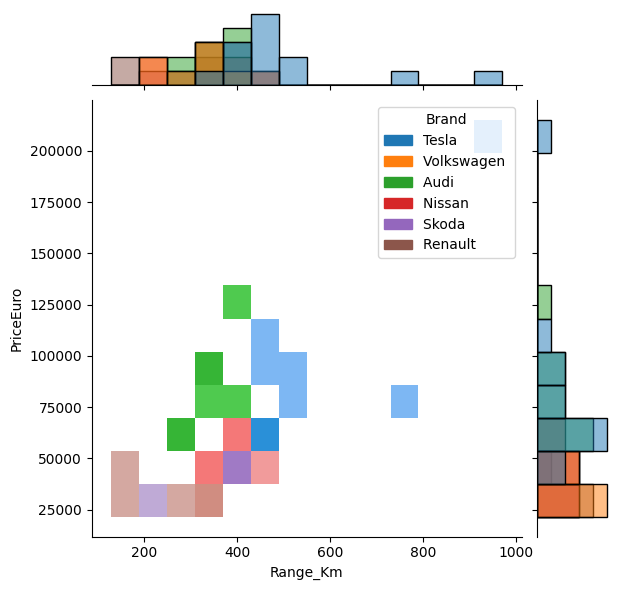

In [121]:
sns.jointplot(
    data=filtered_df,
    x='Range_Km',
    y='PriceEuro',
    kind='hist',
    hue='Brand'
)
plt.show()

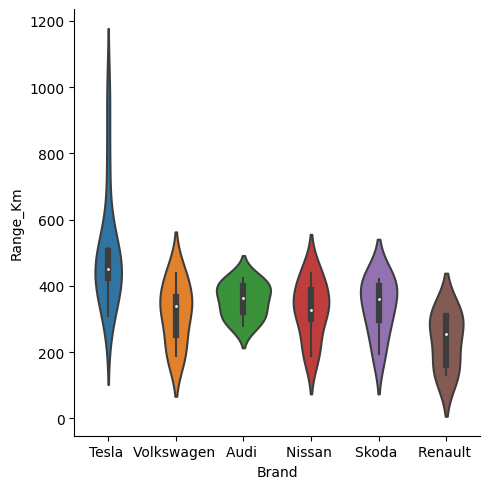

In [139]:
sns.catplot(
    data=filtered_df,
    kind='violin',
    y='Range_Km',
    x='Brand',
    # hue='Brand',
    showfliers=False
)
plt.show()

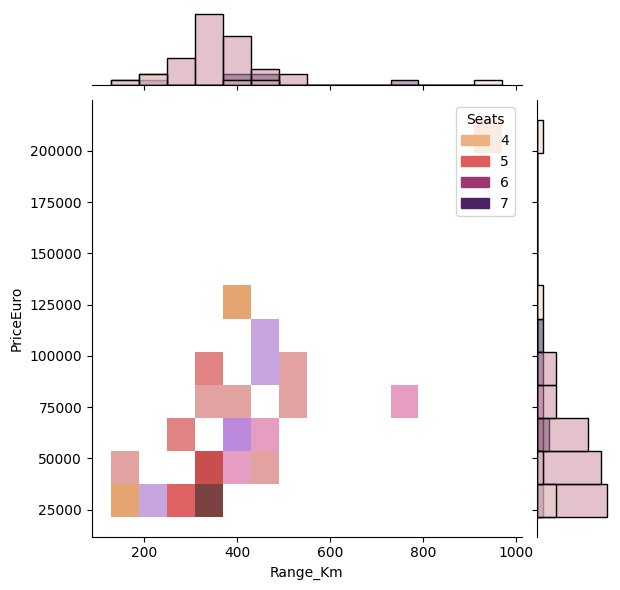

In [133]:
sns.jointplot(
    data=filtered_df,
    x='Range_Km',
    y='PriceEuro',
    kind='hist',
    hue='Seats',
    palette='flare'
)
plt.show()

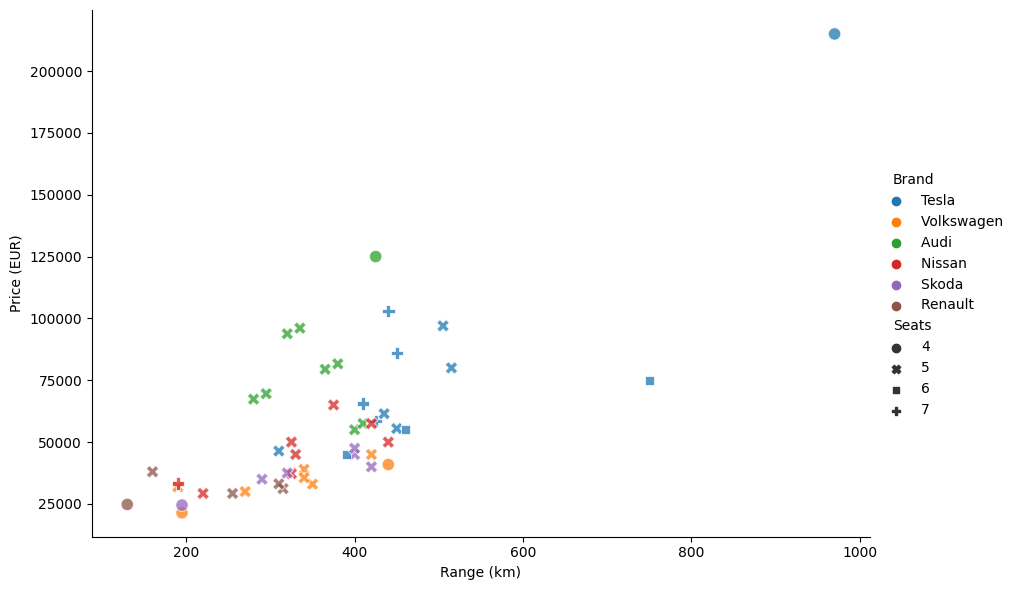

In [144]:
sns.relplot(
    data=filtered_df,
    kind='scatter',
    x='Range_Km',
    y='PriceEuro',
    s=80,
    alpha=0.75,
    height=6,
    aspect=1.5,
    hue='Brand',
    style='Seats',
)
plt.ylabel('Price (EUR)')
plt.xlabel('Range (km)')
# plt.plot(fx_1, fy_1, color='black', linestyle='-')
plt.show()

### **Multiple linear regression analysis**

In [149]:
model_1 = (
    smf.ols(
        formula='PriceEuro ~ Range_Km',
        data=filtered_df
    ).fit()
)

model_1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              PriceEuro   R-squared:                       0.558
Model:                            OLS   Adj. R-squared:                  0.548
Method:                 Least Squares   F-statistic:                     59.25
Date:                Sun, 27 Aug 2023   Prob (F-statistic):           7.23e-10
Time:                        14:45:30   Log-Likelihood:                -558.66
No. Observations:                  49   AIC:                             1121.
Df Residuals:                      47   BIC:                             1125.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept  -8283.0781   9064.176     -0.914      0.365   -2.65e+04    9951.692
Range_Km     177.2002     23.021      7.697      0.000     130.887     223.513
==============================================================================
Omnibus:                        6.650   Durbin-Watson:                   2.246
Prob(Omnibus):                  0.036   Jarque-Bera (JB):                5.630
Skew:                           0.788   Prob(JB):                       0.0599
Kurtosis:                       3.526   Cond. No.                     1.13e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.13e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [151]:
model_2 = (
    smf.ols(
        formula='PriceEuro ~ Range_Km + Efficiency_WhKm',
        data=filtered_df
    ).fit()
)

model_2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              PriceEuro   R-squared:                       0.610
Model:                            OLS   Adj. R-squared:                  0.593
Method:                 Least Squares   F-statistic:                     35.98
Date:                Sun, 27 Aug 2023   Prob (F-statistic):           3.92e-10
Time:                        14:45:52   Log-Likelihood:                -555.57
No. Observations:                  49   AIC:                             1117.
Df Residuals:                      46   BIC:                             1123.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept       -5.115e+04   1.93e+04     -2.655      0.011   -8.99e+04   -1.24e+04
Range_Km          158.8741     23.057      6.890      0.000     112.462     205.286
Efficiency_WhKm   255.7105    102.825      2.487      0.017      48.734     462.686
==============================================================================
Omnibus:                        7.578   Durbin-Watson:                   2.289
Prob(Omnibus):                  0.023   Jarque-Bera (JB):               10.952
Skew:                           0.361   Prob(JB):                      0.00419
Kurtosis:                       5.201   Cond. No.                     2.80e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.8e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [152]:
model_3 = (
    smf.ols(
        formula='PriceEuro ~ Range_Km + Efficiency_WhKm + TopSpeed_KmH',
        data=filtered_df
    ).fit()
)

model_3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              PriceEuro   R-squared:                       0.859
Model:                            OLS   Adj. R-squared:                  0.850
Method:                 Least Squares   F-statistic:                     91.41
Date:                Sun, 27 Aug 2023   Prob (F-statistic):           3.63e-19
Time:                        14:46:37   Log-Likelihood:                -530.65
No. Observations:                  49   AIC:                             1069.
Df Residuals:                      45   BIC:                             1077.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept       -9.121e+04   1.25e+04     -7.271      0.000   -1.16e+05   -6.59e+04
Range_Km            7.3507     22.031      0.334      0.740     -37.021      51.723
Efficiency_WhKm   237.8896     62.540      3.804      0.000     111.927     363.852
TopSpeed_KmH      530.3515     59.491      8.915      0.000     410.531     650.172
==============================================================================
Omnibus:                        5.989   Durbin-Watson:                   2.598
Prob(Omnibus):                  0.050   Jarque-Bera (JB):                6.788
Skew:                           0.353   Prob(JB):                       0.0336
Kurtosis:                       4.681   Cond. No.                     3.28e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.28e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [159]:
model_4 = (
    smf.ols(
        formula='PriceEuro ~ Range_Km + Efficiency_WhKm + TopSpeed_KmH + AccelSec + Seats',
        data=filtered_df
    ).fit()
)

model_4.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              PriceEuro   R-squared:                       0.895
Model:                            OLS   Adj. R-squared:                  0.883
Method:                 Least Squares   F-statistic:                     73.11
Date:                Sun, 27 Aug 2023   Prob (F-statistic):           6.61e-20
Time:                        14:48:43   Log-Likelihood:                -523.49
No. Observations:                  49   AIC:                             1059.
Df Residuals:                      43   BIC:                             1070.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept        -9.92e+04   2.05e+04     -4.834      0.000   -1.41e+05   -5.78e+04
Range_Km           14.2122     19.953      0.712      0.480     -26.028      54.452
Efficiency_WhKm   303.4262     57.881      5.242      0.000     186.697     420.155
TopSpeed_KmH      601.5917     59.213     10.160      0.000     482.178     721.006
AccelSec         1609.2462    721.762      2.230      0.031     153.675    3064.817
Seats           -6277.4167   2229.226     -2.816      0.007   -1.08e+04   -1781.755
==============================================================================
Omnibus:                        3.680   Durbin-Watson:                   2.692
Prob(Omnibus):                  0.159   Jarque-Bera (JB):                3.488
Skew:                           0.093   Prob(JB):                        0.175
Kurtosis:                       4.294   Cond. No.                     6.08e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 6.08e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

#### **Visualizing prediction results**
##### Result table

In [160]:
filtered_df.columns

Index(['Brand', 'Model', 'AccelSec', 'TopSpeed_KmH', 'Range_Km',
       'Efficiency_WhKm', 'FastCharge_KmH', 'RapidCharge', 'PowerTrain',
       'PlugType', 'BodyStyle', 'Segment', 'Seats', 'PriceEuro'],
      dtype='object')

In [165]:
model_results = pd.DataFrame(
    dict(
        actual_value = filtered_df.PriceEuro,
        prediction_model_1 = model_1.predict(),
        prediction_model_2 = model_2.predict(),
        prediction_model_3 = model_3.predict(),
        prediction_model_4 = model_4.predict(),
        brand = filtered_df.Brand,
        model = filtered_df.Model,
        rapid_charge = filtered_df.RapidCharge,
        plug_type = filtered_df.PlugType,
        body_style = filtered_df.BodyStyle,
        # seats = filtered_df.Seats,
        power_train = filtered_df.PowerTrain
    )
)

model_results.head()

,actual_value,prediction_model_1,prediction_model_2,prediction_model_3,prediction_model_4,brand,model,rapid_charge,plug_type,body_style,power_train
0,55480,71456.992246,61509.535724,73974.828789,72230.155257,Tesla,Model 3 Long Range Dual Motor,Yes,Type 2 CCS,Sedan,AWD
1,30000,39560.964097,34446.469155,35363.373649,36266.243640,Volkswagen,ID.3 Pure,Yes,Type 2 CCS,Hatchback,RWD
6,31900,25384.951586,21992.255470,29709.689737,28773.074963,Volkswagen,e-Golf,Yes,Type 2 CCS,Hatchback,FWD
8,46380,46648.970352,37221.484798,66799.797844,64609.543997,Tesla,Model 3 Standard Range Plus,Yes,Type 2 CCS,Sedan,RWD
9,55000,62596.984427,61748.567830,53111.128597,52080.540649,Audi,Q4 e-tron,Yes,Type 2 CCS,SUV,AWD


##### ECDFs

In [167]:
import matplotlib.ticker as ticker

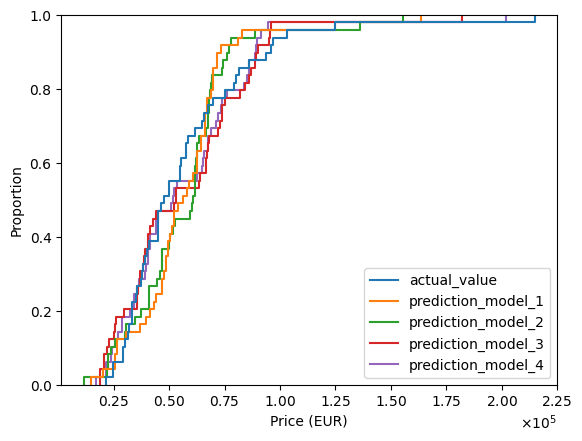

In [171]:
sns.ecdfplot(
    data=model_results
)
plt.gca().xaxis.set_major_formatter(ticker.ScalarFormatter(useMathText=True))
plt.gca().xaxis.get_major_formatter().set_powerlimits((0, 0)) 
plt.xlabel('Price (EUR)')
plt.show()

##### PDFs

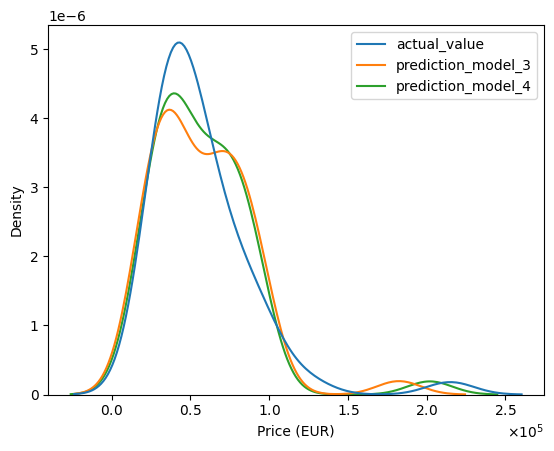

In [179]:
sns.kdeplot(
    data=model_results.select_columns(['actual_value', 'prediction_model_3','prediction_model_4'])
)
plt.gca().xaxis.set_major_formatter(ticker.ScalarFormatter(useMathText=True))
plt.gca().xaxis.get_major_formatter().set_powerlimits((0, 0)) 
plt.xlabel('Price (EUR)')
plt.show()

### **Logistic regression analysis**

This type of regression is useful for predicting classes or tags based on numerical and/or categorical value. In this case, we will try to predict Tesla brand from their price and features, through `smf.logit()`

In [202]:
filtered_df['numeric_brand'] = filtered_df['Brand'].replace(['Tesla ', 'Volkswagen ', 'Audi ', 'Nissan ', 'Skoda ', 'Renault '], [1,0,0,0,0,0])

/tmp/ipykernel_1762/165016978.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['numeric_brand'] = filtered_df['Brand'].replace(['Tesla ', 'Volkswagen ', 'Audi ', 'Nissan ', 'Skoda ', 'Renault '], [1,0,0,0,0,0])


In [203]:
filtered_df.numeric_brand.head()

0    1
1    0
6    0
8    1
9    0
Name: numeric_brand, dtype: int64

In [213]:
filtered_df.columns.values

array(['Brand', 'Model', 'AccelSec', 'TopSpeed_KmH', 'Range_Km',
       'Efficiency_WhKm', 'FastCharge_KmH', 'RapidCharge', 'PowerTrain',
       'PlugType', 'BodyStyle', 'Segment', 'Seats', 'PriceEuro',
       'numeric_brand'], dtype=object)

In [242]:
model_is_tesla = smf.logit(
    formula='numeric_brand ~ Range_Km + Efficiency_WhKm + AccelSec + TopSpeed_KmH',
    data=filtered_df
).fit(maxiter=1000)

model_is_tesla.summary()

Optimization terminated successfully.
         Current function value: 0.191771
         Iterations 9


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:          numeric_brand   No. Observations:                   49
Model:                          Logit   Df Residuals:                       44
Method:                           MLE   Df Model:                            4
Date:                Sun, 27 Aug 2023   Pseudo R-squ.:                  0.6685
Time:                        15:41:05   Log-Likelihood:                -9.3968
converged:                       True   LL-Null:                       -28.348
Covariance Type:            nonrobust   LLR p-value:                 1.174e-07
===================================================================================
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept         -36.8958     16.348     -2.257      0.024     -68.937      -4.855
Range_Km            0.0251      0.014      1.766      0.077      -0.003       0.053
Efficiency_WhKm     0.0106      0.019      0.548      0.583      -0.027       0.049
AccelSec            0.6878      0.439      1.568      0.117      -0.172       1.548
TopSpeed_KmH        0.0993      0.041      2.411      0.016       0.019       0.180
===================================================================================
"""

In [243]:
(
    filtered_df
        .value_counts(['Brand', 'Model', 'BodyStyle', 'RapidCharge'])
        .reset_index(name='count')
        .head()
)

,Brand,Model,BodyStyle,RapidCharge,count
0,Audi,Q4 Sportback e-tron,SUV,Yes,1
1,Skoda,Enyaq iV 80,SUV,Yes,1
2,Skoda,Enyaq iV vRS,SUV,Yes,1
3,Tesla,Cybertruck Dual Motor,Pickup,Yes,1
4,Tesla,Cybertruck Single Motor,Pickup,Yes,1


In [252]:
tesla_df_prediction = pd.DataFrame(
    dict(
        actual_tesla = filtered_df.numeric_brand,
        predicted_values = model_is_tesla.predict().round()
    )
)
tesla_df_prediction

,actual_tesla,predicted_values
0,1,1.0
1,0,0.0
6,0,0.0
8,1,0.0
9,0,0.0
11,0,0.0
15,0,0.0
17,0,0.0
21,1,1.0
22,0,0.0


In [249]:
print(
    sklearn.metrics.confusion_matrix(
        tesla_df_prediction.actual_tesla,
        tesla_df_prediction.predicted_values
    )
)

[[35  1]
 [ 3 10]]


In [251]:
sklearn.metrics.precision_score(
    tesla_df_prediction.actual_tesla,
    tesla_df_prediction.predicted_values
)

0.9090909090909091

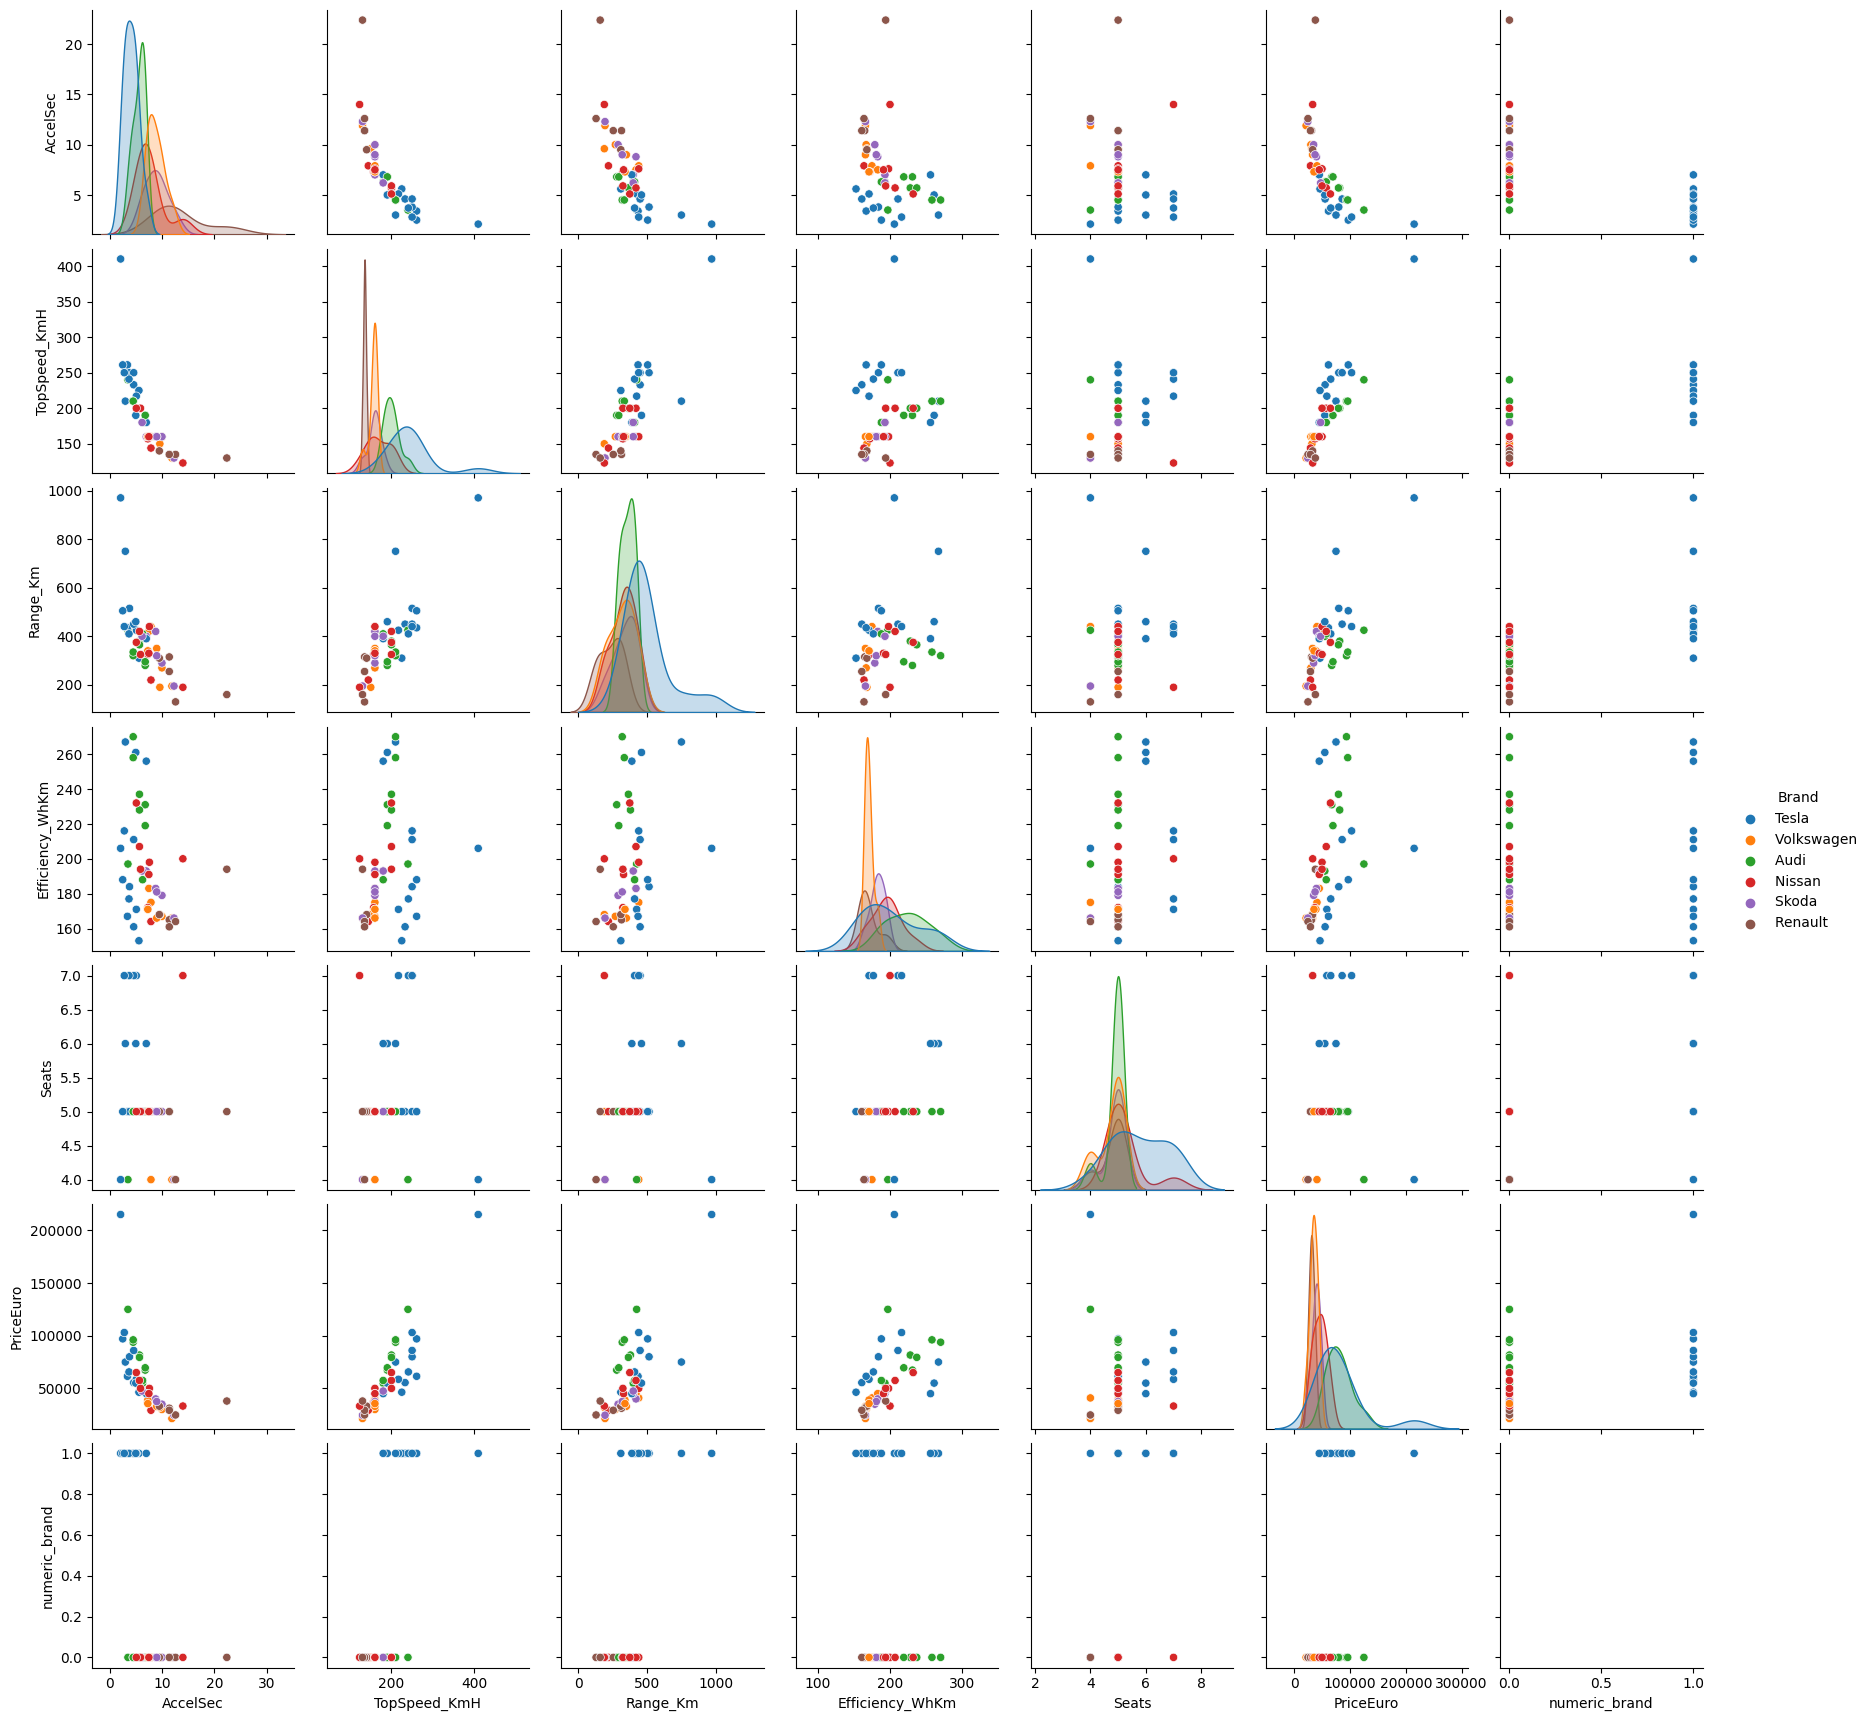

In [255]:
sns.pairplot(
    data=filtered_df,
    hue='Brand'
)
plt.show()

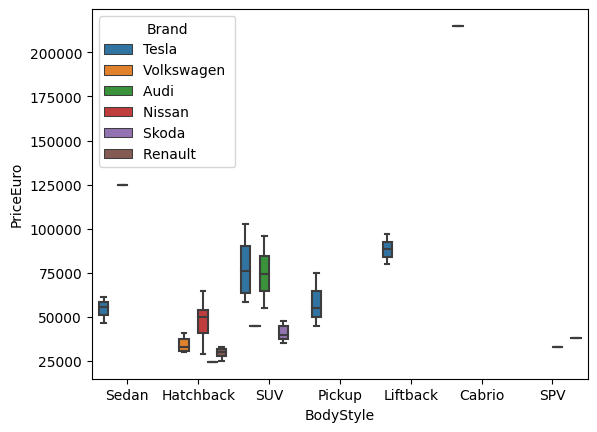

In [245]:
sns.boxplot(
    data=filtered_df,
    x='BodyStyle',
    y='PriceEuro',
    hue='Brand',
    showfliers=False
)
plt.show()